In [1]:
import numpy as np
import dask.array as da
import zarr
from zarr.storage import DirectoryStore
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
ds2 = xr.open_dataset("testout_tmp.zarr", engine="zarr", chunks={"r": "auto"})
ds2

<xarray.Dataset> Size: 105MB
Dimensions:  (i: 18, j: 18, r: 40, xyz: 3, time: 4, k: 42)
Coordinates:
    GRD_x    (i, j, r, xyz) float64 311kB dask.array<chunksize=(18, 18, 40, 3), meta=np.ndarray>
  * time     (time) int64 32B 0 1 2 3
Dimensions without coordinates: i, j, r, xyz, k
Data variables:
    RHOG     (time, i, j, k, r) float64 17MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGE    (time, i, j, k, r) float64 17MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVX   (time, i, j, k, r) float64 17MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVY   (time, i, j, k, r) float64 17MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGVZ   (time, i, j, k, r) float64 17MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
    RHOGW    (time, i, j, k, r) float64 17MB dask.array<chunksize=(1, 18, 18, 42, 40), meta=np.ndarray>
Attributes:
    config:   some\n            longer config\n            
    history:  derived from ...
    title:    fancy simulation

In [3]:
def join_halo(ds):
    return ds.isel(i=slice(1, -1), j=slice(1, -1)).stack(cell=("r", "i", "j"))

In [4]:
ds3 = ds2.pipe(join_halo)
ds3

<xarray.Dataset> Size: 83MB
Dimensions:  (xyz: 3, cell: 10240, time: 4, k: 42)
Coordinates:
    GRD_x    (xyz, cell) float64 246kB dask.array<chunksize=(3, 10240), meta=np.ndarray>
  * time     (time) int64 32B 0 1 2 3
  * cell     (cell) object 82kB MultiIndex
  * r        (cell) int64 82kB 0 0 0 0 0 0 0 0 0 ... 39 39 39 39 39 39 39 39 39
  * i        (cell) int64 82kB 0 0 0 0 0 0 0 0 0 ... 15 15 15 15 15 15 15 15 15
  * j        (cell) int64 82kB 0 1 2 3 4 5 6 7 8 9 ... 6 7 8 9 10 11 12 13 14 15
Dimensions without coordinates: xyz, k
Data variables:
    RHOG     (time, k, cell) float64 14MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGE    (time, k, cell) float64 14MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVX   (time, k, cell) float64 14MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVY   (time, k, cell) float64 14MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGVZ   (time, k, cell) float64 14MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
    RHOGW    (time, k, cell) float64 14MB dask.array<chunksize=(1, 42, 10240), meta=np.ndarray>
Attributes:
    config:   some\n            longer config\n            
    history:  derived from ...
    title:    fancy simulation

In [5]:
from scipy.spatial import KDTree
import cartopy.crs as ccrs
import cartopy.feature as cf

def kd_resample(var, tree, xlims, ylims, nx, ny, src_crs, method="nearest", nest=True):
    # NOTE: we want the center coordinate of each pixel, thus we have to
    # compute the linspace over half a pixel size less than the plot's limits
    dx = (xlims[1] - xlims[0]) / nx
    dy = (ylims[1] - ylims[0]) / ny
    xvals = np.linspace(xlims[0] + dx / 2, xlims[1] - dx / 2, nx)
    yvals = np.linspace(ylims[0] + dy / 2, ylims[1] - dy / 2, ny)
    xvals2, yvals2 = np.meshgrid(xvals, yvals)
    print("computing points")
    latlon = ccrs.PlateCarree().transform_points(
        src_crs, xvals2, yvals2, np.zeros_like(xvals2)
    )
    valid = np.all(np.isfinite(latlon), axis=-1)
    points = latlon[valid].T
    lon = np.deg2rad(points[0])
    lat = np.deg2rad(points[1])
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    
    
    print("preparing output")
    res = np.full(latlon.shape[:-1], np.nan, dtype=var.dtype)

    if method == "nearest":
        print("querying tree")
        dist, pix = tree.query(np.stack([x, y, z], axis=-1))
        print("getting data")
        res[valid] = var[pix]
    elif method == "linear":
        print("querying tree")
        dist, pix = tree.query(np.stack([x, y, z], axis=-1), k=6)
        w = 1 / dist
        total_w = np.sum(w, axis=-1)
        w = w / total_w[..., np.newaxis]
        print("getting data")
        res[valid] = np.sum(var.values[pix] * w, axis=-1)
    else:
        raise ValueError(f"interpolation method '{method}' not known")
    print("resampling done")
    return xr.DataArray(res, coords=[("y", yvals), ("x", xvals)])


def create_geoaxis(add_coastlines=True, **subplot_kw):
    """Convenience function to create a figure with a default map projection."""
    if "projection" not in subplot_kw:
        subplot_kw["projection"] = ccrs.Robinson(central_longitude=-135.58)

    _, ax = plt.subplots(subplot_kw=subplot_kw)
    ax.set_global()

    if add_coastlines:
        ax.coastlines(color="#333333", linewidth=plt.rcParams["grid.linewidth"])

    return ax


def get_current_geoaxis(**kwargs):
    """Return current axis, if it is a GeoAxes, otherwise create a new one."""
    # `plt.gcf().axes` only checks existing axes, while `plt.gca()` also creates one
    if (ax := plt.gcf().axes) and isinstance(ax[0], geoaxes.GeoAxes):
        return ax[0]
    else:
        return create_geoaxis(**kwargs)


def kd_show(
    var,
    tree,
    dpi=None,
    ax=None,
    method="nearest",
    nest=True,
    add_coastlines=True,
    antialias=False,
    **kwargs,
):
    if ax is None:
        ax = get_current_geoaxis(add_coastlines=add_coastlines)
    fig = ax.get_figure()

    if dpi is not None:
        fig.set_dpi(dpi)

    _, _, nx, ny = np.array(ax.bbox.bounds, dtype=int)

    if antialias:
        nx *= 2
        ny *= 2

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    im = kd_resample(var, tree, xlims, ylims, nx, ny, ax.projection, method, nest)

    return ax.imshow(im, extent=xlims + ylims, origin="lower", **kwargs)


def kd_contour(
    var, tree, dpi=None, ax=None, method="linear", nest=True, add_coastlines=True, **kwargs
):
    if ax is None:
        ax = get_current_geoaxis(add_coastlines=add_coastlines)
    fig = ax.get_figure()

    if dpi is not None:
        fig.set_dpi(dpi)

    _, _, nx, ny = np.array(ax.bbox.bounds, dtype=int)

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    im = kd_resample(var, tree, xlims, ylims, nx, ny, ax.projection, method, nest)

    return ax.contour(im.x, im.y, im, **kwargs)

In [6]:
def normalize(var):
    n = np.linalg.norm(var, axis=-1)
    return var / n[..., np.newaxis]
tree = KDTree(normalize(ds3.GRD_x.transpose("cell",  "xyz").values))

In [7]:
def worldmap(var, tree, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=180)
    #projection = ccrs.NearsidePerspective()
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    sm = kd_show(var, tree, ax=ax, **kwargs)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    plt.colorbar(sm, ax=ax)
    return #fig

computing points
preparing output
querying tree
getting data
resampling done


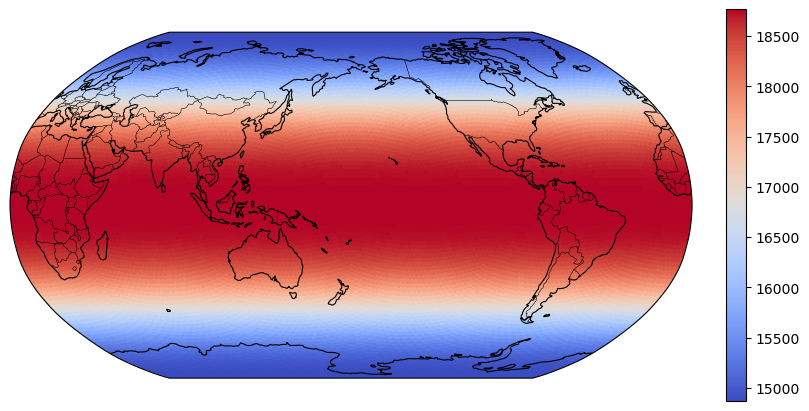

In [8]:
worldmap((ds3.RHOGE).isel(time=1, k=25), tree, cmap="coolwarm")#, vmin=0.25, vmax=0.75)